In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [ ]:
# dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
# root_dir = os.path.join(data_dir, "BSDS500/data")

In [ ]:
root_dir = '/content/drive/MyDrive/DL/AID/Airport'

In [ ]:
crop_size = 300
upscale_factor = 4
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 360 files belonging to 1 classes.
Using 288 files for training.
Found 360 files belonging to 1 classes.
Using 72 files for validation.


In [ ]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [ ]:
#dataset = os.path.join(root_dir, "Airport")
test_path = '/content/drive/MyDrive/DL/Test'

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [ ]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [ ]:

def get_model(upscale_factor=4, channels=1):
    conv_args1 = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

    conv_args2 = {
        "activation": "tanh",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(32, 3, **conv_args2)(inputs)
    x = layers.Conv2D(64, 3, **conv_args1)(x)
    x = layers.Conv2D(32, 3, **conv_args2)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args1)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [ ]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 5 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    320       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

## Train the model

Epoch 1/50
Mean PSNR for epoch: 20.11


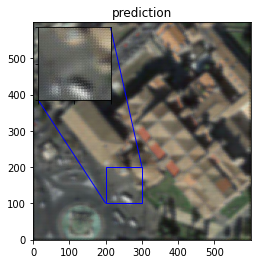

36/36 - 33s - loss: 0.0409 - val_loss: 0.0101 - 33s/epoch - 919ms/step
Epoch 2/50
Mean PSNR for epoch: 22.30
36/36 - 3s - loss: 0.0080 - val_loss: 0.0061 - 3s/epoch - 97ms/step
Epoch 3/50
Mean PSNR for epoch: 23.14
36/36 - 3s - loss: 0.0058 - val_loss: 0.0050 - 3s/epoch - 97ms/step
Epoch 4/50
Mean PSNR for epoch: 23.44
36/36 - 4s - loss: 0.0050 - val_loss: 0.0044 - 4s/epoch - 98ms/step
Epoch 5/50
Mean PSNR for epoch: 24.09
36/36 - 3s - loss: 0.0045 - val_loss: 0.0040 - 3s/epoch - 97ms/step
Epoch 6/50
Mean PSNR for epoch: 24.50


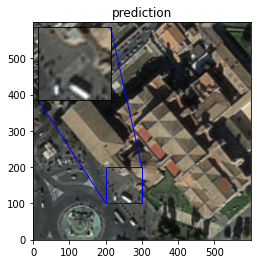

36/36 - 4s - loss: 0.0042 - val_loss: 0.0038 - 4s/epoch - 122ms/step
Epoch 7/50
Mean PSNR for epoch: 24.20
36/36 - 3s - loss: 0.0040 - val_loss: 0.0037 - 3s/epoch - 95ms/step
Epoch 8/50
Mean PSNR for epoch: 24.59
36/36 - 4s - loss: 0.0039 - val_loss: 0.0037 - 4s/epoch - 102ms/step
Epoch 9/50
Mean PSNR for epoch: 24.45
36/36 - 4s - loss: 0.0038 - val_loss: 0.0036 - 4s/epoch - 97ms/step
Epoch 10/50
Mean PSNR for epoch: 24.07
36/36 - 3s - loss: 0.0038 - val_loss: 0.0038 - 3s/epoch - 96ms/step
Epoch 11/50
Mean PSNR for epoch: 24.33


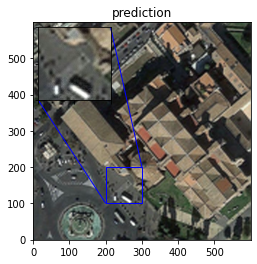

36/36 - 5s - loss: 0.0038 - val_loss: 0.0037 - 5s/epoch - 150ms/step
Epoch 12/50
Mean PSNR for epoch: 24.68
36/36 - 4s - loss: 0.0037 - val_loss: 0.0035 - 4s/epoch - 99ms/step
Epoch 13/50
Mean PSNR for epoch: 24.67
36/36 - 3s - loss: 0.0037 - val_loss: 0.0034 - 3s/epoch - 97ms/step
Epoch 14/50
Mean PSNR for epoch: 24.71
36/36 - 3s - loss: 0.0037 - val_loss: 0.0034 - 3s/epoch - 96ms/step
Epoch 15/50
Mean PSNR for epoch: 24.52
36/36 - 4s - loss: 0.0037 - val_loss: 0.0035 - 4s/epoch - 116ms/step
Epoch 16/50
Mean PSNR for epoch: 25.01


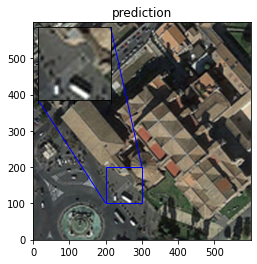

36/36 - 5s - loss: 0.0036 - val_loss: 0.0034 - 5s/epoch - 141ms/step
Epoch 17/50
Mean PSNR for epoch: 24.93
36/36 - 3s - loss: 0.0036 - val_loss: 0.0034 - 3s/epoch - 96ms/step
Epoch 18/50
Mean PSNR for epoch: 24.52
36/36 - 3s - loss: 0.0036 - val_loss: 0.0034 - 3s/epoch - 97ms/step
Epoch 19/50
Mean PSNR for epoch: 24.57
36/36 - 3s - loss: 0.0036 - val_loss: 0.0034 - 3s/epoch - 95ms/step
Epoch 20/50
Mean PSNR for epoch: 24.80
36/36 - 4s - loss: 0.0036 - val_loss: 0.0034 - 4s/epoch - 114ms/step
Epoch 21/50
Mean PSNR for epoch: 24.69


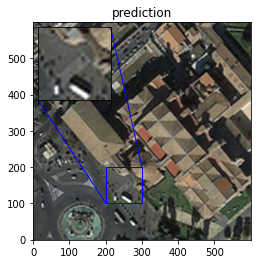

36/36 - 5s - loss: 0.0036 - val_loss: 0.0034 - 5s/epoch - 139ms/step
Epoch 22/50
Mean PSNR for epoch: 24.65
36/36 - 4s - loss: 0.0036 - val_loss: 0.0034 - 4s/epoch - 99ms/step
Epoch 23/50
Mean PSNR for epoch: 24.75
36/36 - 4s - loss: 0.0036 - val_loss: 0.0034 - 4s/epoch - 123ms/step
Epoch 24/50
Mean PSNR for epoch: 24.47
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 98ms/step
Epoch 25/50
Mean PSNR for epoch: 24.76
36/36 - 4s - loss: 0.0035 - val_loss: 0.0034 - 4s/epoch - 115ms/step
Epoch 26/50
Mean PSNR for epoch: 25.21


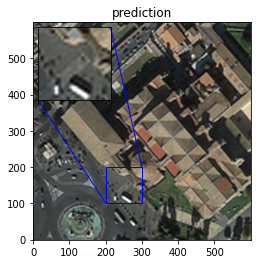

36/36 - 4s - loss: 0.0037 - val_loss: 0.0034 - 4s/epoch - 122ms/step
Epoch 27/50
Mean PSNR for epoch: 24.62
36/36 - 4s - loss: 0.0036 - val_loss: 0.0033 - 4s/epoch - 97ms/step
Epoch 28/50
Mean PSNR for epoch: 24.95
36/36 - 4s - loss: 0.0036 - val_loss: 0.0033 - 4s/epoch - 114ms/step
Epoch 29/50
Mean PSNR for epoch: 24.68
36/36 - 5s - loss: 0.0035 - val_loss: 0.0034 - 5s/epoch - 126ms/step
Epoch 30/50
Mean PSNR for epoch: 24.81
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 114ms/step
Epoch 31/50
Mean PSNR for epoch: 24.36


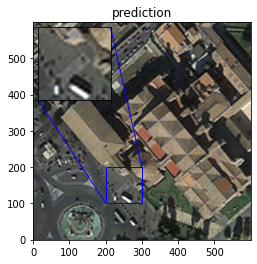

36/36 - 4s - loss: 0.0035 - val_loss: 0.0034 - 4s/epoch - 123ms/step
Epoch 32/50
Mean PSNR for epoch: 24.69
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 114ms/step
Epoch 33/50
Mean PSNR for epoch: 24.49
36/36 - 4s - loss: 0.0035 - val_loss: 0.0034 - 4s/epoch - 100ms/step
Epoch 34/50
Mean PSNR for epoch: 24.54
36/36 - 4s - loss: 0.0036 - val_loss: 0.0033 - 4s/epoch - 116ms/step
Epoch 35/50
Mean PSNR for epoch: 25.47
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 115ms/step
Epoch 36/50
Mean PSNR for epoch: 24.34


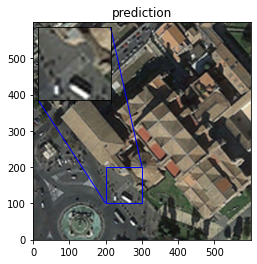

36/36 - 5s - loss: 0.0035 - val_loss: 0.0036 - 5s/epoch - 147ms/step
Epoch 37/50
Mean PSNR for epoch: 24.41
36/36 - 4s - loss: 0.0038 - val_loss: 0.0034 - 4s/epoch - 114ms/step
Epoch 38/50
Mean PSNR for epoch: 24.94
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 113ms/step
Epoch 39/50
Mean PSNR for epoch: 24.44
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 115ms/step
Epoch 40/50
Mean PSNR for epoch: 24.79
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 115ms/step
Epoch 41/50
Mean PSNR for epoch: 24.77


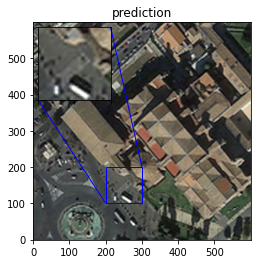

36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 124ms/step
Epoch 42/50
Mean PSNR for epoch: 24.76
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 117ms/step
Epoch 43/50
Mean PSNR for epoch: 24.58
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 116ms/step
Epoch 44/50
Mean PSNR for epoch: 24.70
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 98ms/step
Epoch 45/50
Mean PSNR for epoch: 24.74
36/36 - 3s - loss: 0.0037 - val_loss: 0.0037 - 3s/epoch - 97ms/step
Epoch 46/50
Mean PSNR for epoch: 24.50


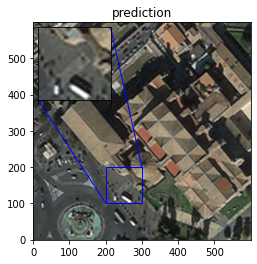

36/36 - 5s - loss: 0.0036 - val_loss: 0.0033 - 5s/epoch - 141ms/step
Epoch 47/50
Mean PSNR for epoch: 24.91
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 99ms/step
Epoch 48/50
Mean PSNR for epoch: 24.75
36/36 - 4s - loss: 0.0035 - val_loss: 0.0033 - 4s/epoch - 115ms/step
Epoch 49/50
Mean PSNR for epoch: 24.80
36/36 - 4s - loss: 0.0034 - val_loss: 0.0033 - 4s/epoch - 114ms/step
Epoch 50/50
Mean PSNR for epoch: 24.86
36/36 - 4s - loss: 0.0034 - val_loss: 0.0033 - 4s/epoch - 115ms/step


In [ ]:
epochs = 10

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 23.4588
PSNR of predict and high resolution is 23.9356


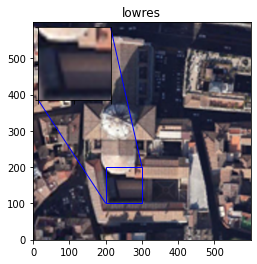

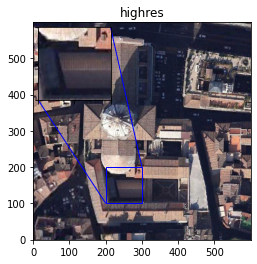

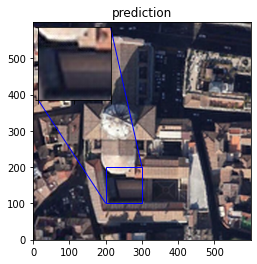

PSNR of low resolution image and high resolution image is 19.8779
PSNR of predict and high resolution is 20.2323


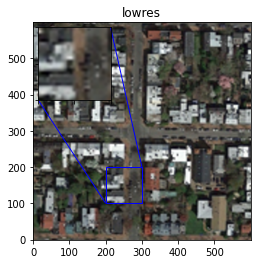

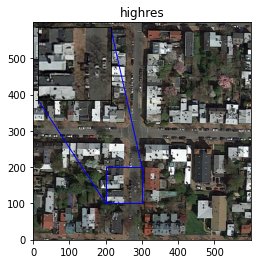

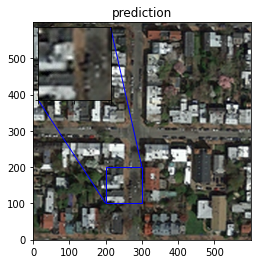

Avg. PSNR of lowres images is 4.3337
Avg. PSNR of reconstructions is 4.4168


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[1:3]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [ ]:
model.summary()
model.save('saved_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    320       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             